# "Quality of life actually begins at home - it's in your street, around your community." 
##                              *- Charles Kennedy -*

### The aim of this project is to develop a tool that may help people in their search for their new house. The key idea is that even though the main determinant for such a choice likely would be the house price, one should not focus only on this, but also understand what surrounds her future home, what characterizes the neighborhood she will be moving to. Filtering locations based on what the buyer is looking for in terms of nearby amenities and distance from a possible workplace, this notebook will try and help her make a decision as much informed as possible


## Step 0: Import Main libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Step 1: Create the dataframes

### The tools in this notebook can be extended to any city, for sake of demonstration I have chosen the city of Paris, since I am currently living there.
### The 'city of Lights' is made of 20 neighborhoods, called *arrondissements*, each of which is then composed of several administrative quartiers. For this study, mainly two datasets have been implemented, one storing the information of the *arrondissements*, such as coordinates, geometry, name, number and postal code, while the second stores the values of all the administrative quartiers. It is possible to find both these datasets and much more [here](https://opendata.paris.fr/explore/?sort=modified "Open Data Paris").

In [2]:
#Open arrondissements dataset
with open('arrondissements.json') as arr_data:
    arrondissement_data = json.load(arr_data)

In [3]:
arrondissement_data

[{'datasetid': 'arrondissements',
  'recordid': 'fdcdd162efd8d445fdecb7b95ed7df1ff4c59f26',
  'fields': {'n_sq_co': 750001537,
   'perimetre': 4554.10435957,
   'objectid': 2,
   'l_ar': '2ème Ardt',
   'geom_x_y': [48.86827922252252, 2.3428025468913636],
   'surface': 991153.74474596,
   'longueur': 4553.93876373,
   'geom': {'type': 'Polygon',
    'coordinates': [[[2.351518483670821, 48.8644258050741],
      [2.350949105218923, 48.86340592861751],
      [2.346676032763327, 48.864430925901665],
      [2.346675453051013, 48.86443106483368],
      [2.345101655171463, 48.864809197959836],
      [2.341271025930368, 48.86572767724484],
      [2.34126849090564, 48.86572828653819],
      [2.341204510696185, 48.865743681005995],
      [2.341178272058699, 48.86574963323163],
      [2.341083555178273, 48.86577201721946],
      [2.337371969067098, 48.86664907439458],
      [2.335869691238243, 48.86699647535598],
      [2.335869054057415, 48.86699662650754],
      [2.333675321300195, 48.867516125

In [3]:
# define the dataframe columns
column_names = ['Arr. Number', 'Arr. Name', 'Latitude', 'Longitude', 'Postal Code'] 

# instantiate the dataframe
arrondissements_df = pd.DataFrame(columns=column_names)

In [4]:
for data in arrondissement_data:
    l_ar = arr_number = data['fields']['l_ar'] 
    l_aroff = arr_name = data['fields']['l_aroff']
        
    arr_latlon = data['geometry']['coordinates']
    arr_lat = arr_latlon[1]
    arr_lon = arr_latlon[0]
    c_arinsee = arr_postcode = data['fields']['c_arinsee']
    
    arrondissements_df = arrondissements_df.append({'Arr. Number': arr_number,
                                          'Arr. Name': arr_name,
                                          'Latitude': arr_lat,
                                          'Longitude': arr_lon,
                                          'Postal Code': c_arinsee}, ignore_index=True)

In [6]:
arrondissements_df

Arr. Number            Arr. Name   Latitude  Longitude Postal Code
0    2ème Ardt               Bourse  48.868279   2.342803       75102
1    3ème Ardt               Temple  48.862872   2.360001       75103
2   12ème Ardt              Reuilly  48.834974   2.421325       75112
3     1er Ardt               Louvre  48.862563   2.336443       75101
4    4ème Ardt       Hôtel-de-Ville  48.854341   2.357630       75104
5    8ème Ardt               Élysée  48.872721   2.312554       75108
6   14ème Ardt         Observatoire  48.829245   2.326542       75114
7   19ème Ardt      Buttes-Chaumont  48.887076   2.384821       75119
8   20ème Ardt         Ménilmontant  48.863461   2.401188       75120
9    6ème Ardt           Luxembourg  48.849130   2.332898       75106
10   9ème Ardt                Opéra  48.877164   2.337458       75109
11  17ème Ardt  Batignolles-Monceau  48.887327   2.306777       75117
12  15ème Ardt            Vaugirard  48.840085   2.292826       75115
13   5ème Ardt             Panthéon  48.844443   2.350715       75105
14   7ème Ardt       Palais-Bourbon  48.856174   2.312188       75107
15  10ème Ardt             Entrepôt  48.876130   2.360728       75110
16  11ème Ardt           Popincourt  48.859059   2.380058       75111
17  13ème Ardt             Gobelins  48.828388   2.362272       75113
18  16ème Ardt                Passy  48.860392   2.261971       75116
19  18ème Ardt    Buttes-Montmartre  48.892569   2.348161       75118

In [5]:
arrondissements_df.sort_values(['Postal Code'], axis=0, ascending=True).reset_index().drop(['index'], axis = 1)

Arr. Number            Arr. Name   Latitude  Longitude Postal Code
0     1er Ardt               Louvre  48.862563   2.336443       75101
1    2ème Ardt               Bourse  48.868279   2.342803       75102
2    3ème Ardt               Temple  48.862872   2.360001       75103
3    4ème Ardt       Hôtel-de-Ville  48.854341   2.357630       75104
4    5ème Ardt             Panthéon  48.844443   2.350715       75105
5    6ème Ardt           Luxembourg  48.849130   2.332898       75106
6    7ème Ardt       Palais-Bourbon  48.856174   2.312188       75107
7    8ème Ardt               Élysée  48.872721   2.312554       75108
8    9ème Ardt                Opéra  48.877164   2.337458       75109
9   10ème Ardt             Entrepôt  48.876130   2.360728       75110
10  11ème Ardt           Popincourt  48.859059   2.380058       75111
11  12ème Ardt              Reuilly  48.834974   2.421325       75112
12  13ème Ardt             Gobelins  48.828388   2.362272       75113
13  14ème Ardt         Observatoire  48.829245   2.326542       75114
14  15ème Ardt            Vaugirard  48.840085   2.292826       75115
15  16ème Ardt                Passy  48.860392   2.261971       75116
16  17ème Ardt  Batignolles-Monceau  48.887327   2.306777       75117
17  18ème Ardt    Buttes-Montmartre  48.892569   2.348161       75118
18  19ème Ardt      Buttes-Chaumont  48.887076   2.384821       75119
19  20ème Ardt         Ménilmontant  48.863461   2.401188       75120

In [6]:
#  Open quartiers dataset
with open('quartier_paris.json') as qrt_data:
    quartiers_data = json.load(qrt_data)

In [9]:
quartiers_data

[{'datasetid': 'quartier_paris',
  'recordid': '9666923f5fd0b58c759554b079194bfe8289a289',
  'fields': {'n_sq_qu': 750000010,
   'perimetre': 2139.62538775,
   'objectid': 50,
   'longueur': 2139.5355911,
   'c_qu': 10,
   'surface': 271750.32393656,
   'geom_x_y': [48.86388739200148, 2.3631233009869512],
   'geom': {'type': 'Polygon',
    'coordinates': [[[2.367101341254551, 48.86162755885409],
      [2.367265176116383, 48.86094919413814],
      [2.363560968606968, 48.86147027305098],
      [2.361225279064903, 48.86179542267097],
      [2.359812353799636, 48.862601603581574],
      [2.358758689067378, 48.86315994208899],
      [2.358376790869217, 48.863331544411615],
      [2.358265473420907, 48.86336590690384],
      [2.3584034898810122, 48.86354959975191],
      [2.3588510511819463, 48.864001734507674],
      [2.359335215112276, 48.86442913978287],
      [2.359536635370187, 48.86462500317124],
      [2.35965880809718, 48.86469520766889],
      [2.359761463915734, 48.86475463241963],

In [7]:
# define the dataframe columns
column_names2 = ['Name', 'Arrondissement', 'Latitude', 'Longitude', 'Postal Code'] 

# instantiate the dataframe
quartiers_df = pd.DataFrame(columns=column_names2)

In [11]:
quartiers_df

Empty DataFrame
Columns: [Name, Arrondissement, Latitude, Longitude, Postal Code]
Index: []

In [8]:
for data in quartiers_data:
    l_qu = quartier_name = data['fields']['l_qu']
    c_ar = arrondissement = data['fields']['c_ar']
        
    qrt_latlon = data['geometry']['coordinates']
    qrt_lat = qrt_latlon[1]
    qrt_lon = qrt_latlon[0]
    c_quinsee = qrt_postcode = data['fields']['c_quinsee']
    
    quartiers_df = quartiers_df.append({'Name': quartier_name,
                                          'Arrondissement': arrondissement,
                                          'Latitude': qrt_lat,
                                          'Longitude': qrt_lon,
                                          'Postal Code': c_quinsee}, ignore_index=True)

In [13]:
quartiers_df

Name Arrondissement   Latitude  Longitude Postal Code
0              Enfants-Rouges              3  48.863887   2.363123     7510302
1                  Notre-Dame              4  48.852896   2.352775     7510404
2          Jardin-des-Plantes              5  48.841940   2.356894     7510502
3        Saint-Thomas-d'Aquin              7  48.855263   2.325588     7510701
4         Faubourg-Montmartre              9  48.873935   2.343253     7510903
5                Rochechouart              9  48.879812   2.344861     7510904
6           Porte-Saint-Denis             10  48.873618   2.352283     7511002
7          Porte-Saint-Martin             10  48.871245   2.361504     7511003
8           Sainte-Marguerite             11  48.852097   2.388765     7511104
9                       Bercy             12  48.835209   2.386210     7511203
10                     Combat             19  48.878639   2.380127     7511904
11                     Ternes             17  48.881178   2.289964     7511701
12                  Epinettes             17  48.894943   2.321119     7511704
13            Arts-et-Métiers              3  48.866470   2.357083     7510301
14               Sainte-Avoie              3  48.862557   2.354852     7510304
15                    Monnaie              6  48.854384   2.340035     7510601
16      Notre-Dame-des-Champs              6  48.846428   2.327357     7510603
17            Ecole-Militaire              7  48.850359   2.311031     7510703
18              Saint-Georges              9  48.879934   2.332850     7510901
19                     Picpus             12  48.830359   2.428827     7511202
20             Maison-Blanche             13  48.823128   2.352433     7511303
21         Parc-de-Montsouris             14  48.823453   2.337070     7511402
22                  Plaisance             14  48.830317   2.315305     7511404
23               Palais-Royal              1  48.864660   2.336309     7510103
24            Pont-de-Flandre             19  48.895556   2.384777     7511902
25                     Muette             16  48.863275   2.259936     7511602
26                   Chaillot             16  48.868434   2.291679     7511604
27                       Mail              2  48.868008   2.344699     7510203
28                   Archives              3  48.859192   2.363205     7510303
29                    Arsenal              4  48.851585   2.364768     7510403
30               Val-de-Grâce              5  48.841684   2.343861     7510503
31             Champs-Elysées              8  48.867074   2.308652     7510801
32           Chaussée-d'Antin              9  48.873547   2.332269     7510902
33      Saint-Vincent-de-Paul             10  48.880735   2.357471     7511001
34        Hôpital-Saint-Louis             10  48.876008   2.368123     7511004
35            Petit-Montrouge             14  48.826653   2.326437     7511403
36                     Necker             15  48.842711   2.310777     7511502
37  Saint-Germain-l'Auxerrois              1  48.860650   2.334910     7510101
38                   Charonne             20  48.854760   2.407430     7512004
39             Porte-Dauphine             16  48.871766   2.271918     7511603
40         Plaine de Monceaux             17  48.885044   2.302910     7511702
41                Batignolles             17  48.888482   2.313856     7511703
42             Bonne-Nouvelle              2  48.867150   2.350080     7510204
43                Saint-Merri              4  48.858521   2.351667     7510401
44              Saint-Gervais              4  48.855719   2.358162     7510402
45               Saint-Victor              5  48.847664   2.354093     7510501
46                   Sorbonne              5  48.849045   2.345747     7510504
47                      Odéon              6  48.847801   2.336339     7510602
48            Folie-Méricourt             11  48.867403   2.372965     7511101
49                    Bel-Air             12  48.837996   2.433178     7511

In [9]:
quartiers_df = quartiers_df.sort_values(['Arrondissement'], axis=0, ascending=True).reset_index()

In [10]:
quartiers_df = quartiers_df.drop(['index'], axis = 1)

In [11]:
quartiers_df

Name Arrondissement   Latitude  Longitude Postal Code
0   Saint-Germain-l'Auxerrois              1  48.860650   2.334910     7510101
1                      Halles              1  48.862289   2.344899     7510102
2                Palais-Royal              1  48.864660   2.336309     7510103
3               Place-Vendôme              1  48.867019   2.328582     7510104
4                    Vivienne              2  48.869100   2.339461     7510202
5              Bonne-Nouvelle              2  48.867150   2.350080     7510204
6                        Mail              2  48.868008   2.344699     7510203
7                     Gaillon              2  48.869307   2.333432     7510201
8                    Archives              3  48.859192   2.363205     7510303
9                Sainte-Avoie              3  48.862557   2.354852     7510304
10            Arts-et-Métiers              3  48.866470   2.357083     7510301
11             Enfants-Rouges              3  48.863887   2.363123     7510302
12                Saint-Merri              4  48.858521   2.351667     7510401
13                 Notre-Dame              4  48.852896   2.352775     7510404
14                    Arsenal              4  48.851585   2.364768     7510403
15              Saint-Gervais              4  48.855719   2.358162     7510402
16               Val-de-Grâce              5  48.841684   2.343861     7510503
17         Jardin-des-Plantes              5  48.841940   2.356894     7510502
18                   Sorbonne              5  48.849045   2.345747     7510504
19               Saint-Victor              5  48.847664   2.354093     7510501
20                    Monnaie              6  48.854384   2.340035     7510601
21      Notre-Dame-des-Champs              6  48.846428   2.327357     7510603
22                      Odéon              6  48.847801   2.336339     7510602
23     Saint-Germain-des-Prés              6  48.855289   2.333657     7510604
24               Gros-Caillou              7  48.858300   2.301542     7510704
25                  Invalides              7  48.858515   2.316445     7510702
26            Ecole-Militaire              7  48.850359   2.311031     7510703
27       Saint-Thomas-d'Aquin              7  48.855263   2.325588     7510701
28                  Madeleine              8  48.871265   2.320053     7510803
29                     Europe              8  48.878148   2.317175     7510804
30             Champs-Elysées              8  48.867074   2.308652     7510801
31          Faubourg-du-Roule              8  48.874136   2.304119     7510802
32              Saint-Georges              9  48.879934   2.332850     7510901
33        Faubourg-Montmartre              9  48.873935   2.343253     7510903
34           Chaussée-d'Antin              9  48.873547   2.332269     7510902
35               Rochechouart              9  48.879812   2.344861     7510904
36          Porte-Saint-Denis             10  48.873618   2.352283     7511002
37      Saint-Vincent-de-Paul             10  48.880735   2.357471     7511001
38         Porte-Saint-Martin             10  48.871245   2.361504     7511003
39        Hôpital-Saint-Louis             10  48.876008   2.368123     7511004
40                   Roquette             11  48.857064   2.380364     7511103
41             Saint-Ambroise             11  48.862345   2.376118     7511102
42            Folie-Méricourt             11  48.867403   2.372965     7511101
43          Sainte-Marguerite             11  48.852097   2.388765     7511104
44                    Bel-Air             12  48.837996   2.433178     7511201
45              Quinze-Vingts             12  48.846916   2.374402     7511204
46                      Bercy             12  48.835209   2.386210     7511203
47                     Picpus             12  48.830359   2.428827     7511202
48                       Gare             13  48.827527   2.372398     7511302
49                Croulebarbe             13  48.833734   2.347673     7511

## Step 2: Collect venues data

### In order to determine the points of interests in each quartier, FourSquare API will be used. At the end of this part, for each quartier will be produced a list of venues retrieved in them, sorted by their frequencies.

In [12]:
#Geographical data for Paris

address = 'Paris, FR'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566101, 2.3514992.


In [13]:
# @hidden_cell
CLIENT_ID = 'K0AX2YIXDJUOQYQTF5CBAL5VZSPVVFJKFV3QOI0RZIPPPC21' # your Foursquare ID
CLIENT_SECRET = 'RGWNPXTQE1JTAQ2IGB1D5HS1NGT54CUJCUTXTVC4TQL2DTZB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [14]:
quartier_latitude = quartiers_df.loc[0, 'Latitude'] # neighborhood latitude value
quartier_longitude = quartiers_df.loc[0, 'Longitude'] # neighborhood longitude value

quartier_name = quartiers_df.loc[0, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(quartier_name, 
                                                               quartier_latitude, 
                                                               quartier_longitude))

Latitude and longitude values of Saint-Germain-l'Auxerrois are 48.86065013520992, 2.334910329280203.


In [15]:
# Query Foursuqare API in order to retrieve a list of points of interest

LIMIT = 150 

radius = 600
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    quartier_latitude, 
    quartier_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=K0AX2YIXDJUOQYQTF5CBAL5VZSPVVFJKFV3QOI0RZIPPPC21&client_secret=RGWNPXTQE1JTAQ2IGB1D5HS1NGT54CUJCUTXTVC4TQL2DTZB&v=20180605&ll=48.86065013520992,2.334910329280203&radius=600&limit=150'

In [16]:
results = requests.get(url).json()

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name     categories  \
0                                    Musée du Louvre     Art Museum   
1                   La Vénus de Milo (Vénus de Milo)        Exhibit   
2                 Vestige de la Forteresse du Louvre  Historic Site   
3                                      Cour Napoléon          Plaza   
4  Pavillon des Sessions – Arts d'Afrique, d'Asie...     Art Museum   

         lat       lng  
0  48.860847  2.336440  
1  48.859943  2.337234  
2  48.861577  2.333508  
3  48.861172  2.335088  
4  48.860724  2.332121

In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Quartier', 
                  'Quartier Latitude', 
                  'Quartier Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:

Paris_venues = getNearbyVenues(names=quartiers_df['Name'],
                                   latitudes=quartiers_df['Latitude'],
                                   longitudes=quartiers_df['Longitude']
                                  )



Saint-Germain-l'Auxerrois
Halles
Palais-Royal
Place-Vendôme
Vivienne
Bonne-Nouvelle
Mail
Gaillon
Archives
Sainte-Avoie
Arts-et-Métiers
Enfants-Rouges
Saint-Merri
Notre-Dame
Arsenal
Saint-Gervais
Val-de-Grâce
Jardin-des-Plantes
Sorbonne
Saint-Victor
Monnaie
Notre-Dame-des-Champs
Odéon
Saint-Germain-des-Prés
Gros-Caillou
Invalides
Ecole-Militaire
Saint-Thomas-d'Aquin
Madeleine
Europe
Champs-Elysées
Faubourg-du-Roule
Saint-Georges
Faubourg-Montmartre
Chaussée-d'Antin
Rochechouart
Porte-Saint-Denis
Saint-Vincent-de-Paul
Porte-Saint-Martin
Hôpital-Saint-Louis
Roquette
Saint-Ambroise
Folie-Méricourt
Sainte-Marguerite
Bel-Air
Quinze-Vingts
Bercy
Picpus
Gare
Croulebarbe
Salpêtrière
Maison-Blanche
Petit-Montrouge
Plaisance
Parc-de-Montsouris
Montparnasse
Saint-Lambert
Grenelle
Javel
Necker
Auteuil
Porte-Dauphine
Chaillot
Muette
Ternes
Epinettes
Batignolles
Plaine de Monceaux
La Chapelle
Grandes-Carrières
Clignancourt
Goutte-d'Or
Villette
Pont-de-Flandre
Amérique
Combat
Charonne
Saint-Fargeau
Pè

In [28]:
print(Paris_venues.shape)
Paris_venues.head()

(5591, 7)


Quartier  Quartier Latitude  Quartier Longitude  \
0  Saint-Germain-l'Auxerrois           48.86065             2.33491   
1  Saint-Germain-l'Auxerrois           48.86065             2.33491   
2  Saint-Germain-l'Auxerrois           48.86065             2.33491   
3  Saint-Germain-l'Auxerrois           48.86065             2.33491   
4  Saint-Germain-l'Auxerrois           48.86065             2.33491   

                                               Venue  Venue Latitude  \
0                                    Musée du Louvre       48.860847   
1                   La Vénus de Milo (Vénus de Milo)       48.859943   
2                 Vestige de la Forteresse du Louvre       48.861577   
3                                      Cour Napoléon       48.861172   
4  Pavillon des Sessions – Arts d'Afrique, d'Asie...       48.860724   

   Venue Longitude Venue Category  
0         2.336440     Art Museum  
1         2.337234        Exhibit  
2         2.333508  Historic Site  
3         2.335088          Plaza  
4         2.332121     Art Museum

In [22]:
Paris_venues.groupby('Quartier').count()

Quartier Latitude  Quartier Longitude  Venue  \
Quartier                                                                  
Amérique                                  15                  15     15   
Archives                                 100                 100    100   
Arsenal                                   81                  81     81   
Arts-et-Métiers                          100                 100    100   
Auteuil                                   16                  16     16   
Batignolles                              100                 100    100   
Bel-Air                                    6                   6      6   
Belleville                                42                  42     42   
Bercy                                     72                  72     72   
Bonne-Nouvelle                           100                 100    100   
Chaillot                                 100                 100    100   
Champs-Elysées                           100                 100    100   
Charonne                                  35                  35     35   
Chaussée-d'Antin                         100                 100    100   
Clignancourt                              68                  68     68   
Combat                                    33                  33     33   
Croulebarbe                               47                  47     47   
Ecole-Militaire                           20                  20     20   
Enfants-Rouges                           100                 100    100   
Epinettes                                 22                  22     22   
Europe                                    74                  74     74   
Faubourg-Montmartre                      100                 100    100   
Faubourg-du-Roule                        100                 100    100   
Folie-Méricourt                          100                 100    100   
Gaillon                                  100                 100    100   
Gare                                      55                  55     55   
Goutte-d'Or                               30                  30     30   
Grandes-Carrières                         59                  59     59   
Grenelle                                  50                  50     50   
Gros-Caillou                             100                 100    100   
Halles                                   100                 100    100   
Hôpital-Saint-Louis                      100                 100    100   
Invalides                                 55                  55     55   
Jardin-des-Plantes                        66                  66     66   
Javel                                     36                  36     36   
La Chapelle                               16                  16     16   
Madeleine                                100                 100    100   
Mail                                     100                 100    100   
Maison-Blanche                            32                  32     32   
Monnaie                                  100                 100    100   
Montparnasse                              86                  86     86   
Muette                                     7                   7      7   
Necker                                    49                  49     49   
Notre-Dame                               100                 100    100   
Notre-Dame-des-Champs                    100                 100    100   
Odéon                                     97                  97     97   
Palais-Royal                             100                 100    100   
Parc-de-Montsouris                        20                  20     20   
Petit-Montrouge                           73                  73     73   
Picpus                                     2                   2      2   
Place-Vendôme                            100                 100    100   
Plaine de Monceaux                        67        

In [23]:
print('There are {} uniques categories.'.format(len(Paris_venues['Venue Category'].unique())))

There are 301 uniques categories.


In [24]:
# one hot encoding
paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Quartier'] = Paris_venues['Quartier'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

Quartier  Accessories Store  Afghan Restaurant  \
0  Saint-Germain-l'Auxerrois                  0                  0   
1  Saint-Germain-l'Auxerrois                  0                  0   
2  Saint-Germain-l'Auxerrois                  0                  0   
3  Saint-Germain-l'Auxerrois                  0                  0   
4  Saint-Germain-l'Auxerrois                  0                  0   

   African Restaurant  Alsatian Restaurant  American Restaurant  Antique Shop  \
0                   0                    0                    0             0   
1                   0                    0                    0             0   
2                   0                    0                    0             0   
3                   0                    0                    0             0   
4                   0                    0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           1   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           1   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Auvergne Restaurant  BBQ Joint  Baby Store  \
0                   0           0                    0          0           0   
1                   0           0                    0          0           0   
2                   0           0                    0          0           0   
3                   0           0                    0          0           0   
4                   0           0                    0          0           0   

   Bagel Shop  Bakery  Bar  Basketball Court  Basque Restaurant  \
0           0       0    0                 0                  0   
1           0       0    0                 0                  0   
2           0       0    0                 0                  0   
3           0       0    0                 0                  0   
4           0       0    0                 0                  0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
0                0         0            0           0                   0   
1                0         0            0           0                   0   
2                0         0            0           0                   0   
3                0         0            0           0                   0   
4                0         0            0           0                   0   

   Big Box Store  Bike Rental / Bike Share  Bistro  Boat or Ferry  Bookstore  \
0              0                         0       0              0          0   
1              0                         0       0              0          0   
2              0                         0       0              0          0   
3              0                         0       0              0          0   
4              0                         0       0              0          0   

   Botanical Garden  Boutique  Boxing Gym  Brasserie  Brazilian Restaurant  \
0                 0         0           0          0                     0   
1                 0         0           0          0                     0   
2                 0         0           0          0                     0   
3                 0         0           0          0                     0   
4         

In [25]:
paris_grouped = paris_onehot.groupby('Quartier').mean().reset_index()
paris_grouped

Quartier  Accessories Store  Afghan Restaurant  \
0                    Amérique           0.000000           0.000000   
1                    Archives           0.000000           0.000000   
2                     Arsenal           0.000000           0.000000   
3             Arts-et-Métiers           0.000000           0.000000   
4                     Auteuil           0.000000           0.000000   
5                 Batignolles           0.000000           0.000000   
6                     Bel-Air           0.000000           0.000000   
7                  Belleville           0.000000           0.000000   
8                       Bercy           0.000000           0.000000   
9              Bonne-Nouvelle           0.000000           0.000000   
10                   Chaillot           0.000000           0.000000   
11             Champs-Elysées           0.000000           0.000000   
12                   Charonne           0.000000           0.000000   
13           Chaussée-d'Antin           0.000000           0.000000   
14               Clignancourt           0.000000           0.000000   
15                     Combat           0.000000           0.000000   
16                Croulebarbe           0.000000           0.000000   
17            Ecole-Militaire           0.000000           0.000000   
18             Enfants-Rouges           0.000000           0.000000   
19                  Epinettes           0.000000           0.000000   
20                     Europe           0.000000           0.000000   
21        Faubourg-Montmartre           0.000000           0.000000   
22          Faubourg-du-Roule           0.000000           0.000000   
23            Folie-Méricourt           0.000000           0.000000   
24                    Gaillon           0.000000           0.000000   
25                       Gare           0.000000           0.000000   
26                Goutte-d'Or           0.000000           0.000000   
27          Grandes-Carrières           0.000000           0.000000   
28                   Grenelle           0.000000           0.000000   
29               Gros-Caillou           0.000000           0.000000   
30                     Halles           0.000000           0.000000   
31        Hôpital-Saint-Louis           0.000000           0.000000   
32                  Invalides           0.000000           0.000000   
33         Jardin-des-Plantes           0.000000           0.000000   
34                      Javel           0.000000           0.000000   
35                La Chapelle           0.000000           0.000000   
36                  Madeleine           0.000000           0.000000   
37                       Mail           0.000000           0.000000   
38             Maison-Blanche           0.000000           0.000000   
39                    Monnaie           0.000000           0.000000   
40               Montparnasse           0.000000           0.000000   
41                     Muette           0.000000           0.000000   
42                     Necker           0.000000           0.000000   
43                 Notre-Dame           0.000000           0.000000   
44      Notre-Dame-des-Champs           0.000000           0.000000   
45                      Odéon           0.000000           0.000000   
46               Palais-Royal           0.000000           0.000000   
47         Parc-de-Montsouris           0.000000           0.000000   
48            Petit-Montrouge           0.000000           0.000000   
49                     Picpus           0.000000           0.000000   
50              Place-Vendôme           0.020000           0.000000   
51         Plaine de Monceaux           0.000000           0.000000   
52                  Plaisance           0.000000           0.000000   
53            Pont-de-Flandre           0.016949           0.000000   
54             Porte-Dauphine           0.000000           0.000000   
55          Porte-Saint-Denis           0.000


#### **Note 1** : One of the first findings of this study is that... There are really a lot of restaurants in Paris! For this reason, All the 'Restaurant' type venues have been removed, in order later not to have a clustering biased toward a large group of places with restaurants. There is no shortage of places where to eat in Paris, do not worry. For similar reasons I removed also the hotels, as a person looking for a house would have little use of them.

In [26]:
#Remove restaurants from venues
paris_grouped_noRestaurants = paris_grouped
paris_grouped_noRestaurants = paris_grouped_noRestaurants[paris_grouped_noRestaurants.columns.drop(list(paris_grouped_noRestaurants.filter(regex='Restaurant')))]

In [27]:
##Remove hotels from venues
paris_grouped_noRestaurantsandHotels = paris_grouped_noRestaurants[paris_grouped_noRestaurants.columns.drop(list(paris_grouped_noRestaurants.filter(regex='Hotel')))]

In [28]:
#For each quartier, show the most occurring venues
num_top_venues = 5

for hood in paris_grouped_noRestaurantsandHotels['Quartier']:
    print("----"+hood+"----")
    temp = paris_grouped_noRestaurantsandHotels[paris_grouped_noRestaurantsandHotels['Quartier'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
         venue  freq
0        Plaza  0.13
1  Supermarket  0.13
2       Bistro  0.13
3         Park  0.07
4       Bakery  0.07


----Archives----
            venue  freq
0  Clothing Store  0.09
1     Art Gallery  0.08
2     Coffee Shop  0.04
3        Tea Room  0.03
4        Boutique  0.03


----Arsenal----
              venue  freq
0             Plaza  0.04
1         Gastropub  0.04
2     Boat or Ferry  0.02
3     Historic Site  0.02
4  Pedestrian Plaza  0.02


----Arts-et-Métiers----
          venue  freq
0  Cocktail Bar  0.04
1           Bar  0.04
2      Wine Bar  0.03
3   Coffee Shop  0.03
4          Café  0.03


----Auteuil----
                   venue  freq
0           Tennis Court  0.31
1                Stadium  0.12
2                 Garden  0.12
3             Racecourse  0.06
4  Outdoors & Recreation  0.06


----Batignolles----
            venue  freq
0             Bar  0.08
1          Bistro  0.05
2            Café  0.03
3     Pizza Place  0.02
4  Breakfast Spo

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Quartier']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quartiers_venues_sorted = pd.DataFrame(columns=columns)
quartiers_venues_sorted['Quartier'] = paris_grouped_noRestaurantsandHotels['Quartier']

for ind in np.arange(paris_grouped.shape[0]):
    quartiers_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped_noRestaurantsandHotels.iloc[ind, :], num_top_venues)

quartiers_venues_sorted.head()

Quartier 1st Most Common Venue 2nd Most Common Venue  \
0         Amérique                 Plaza                Bistro   
1         Archives        Clothing Store           Art Gallery   
2          Arsenal                 Plaza             Gastropub   
3  Arts-et-Métiers          Cocktail Bar                   Bar   
4          Auteuil          Tennis Court               Stadium   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0           Supermarket                   Park                  Café   
1           Coffee Shop                   Café              Boutique   
2         Historic Site                 Bakery                  Park   
3                  Café               Wine Bar           Coffee Shop   
4                Garden  Outdoors & Recreation                Office   

  6th Most Common Venue     7th Most Common Venue 8th Most Common Venue  \
0           Gas Station  Bike Rental / Bike Share                Bakery   
1              Tea Room              Burger Joint        Sandwich Place   
2           Coffee Shop              Cocktail Bar         Boat or Ferry   
3            Steakhouse                   Theater           Pizza Place   
4                Museum                Racecourse      Botanical Garden   

  9th Most Common Venue 10th Most Common Venue  
0       Bed & Breakfast                   Pool  
1             Bookstore                 Bistro  
2      Pedestrian Plaza                    Gym  
3           Art Gallery              Wine Shop  
4   Sporting Goods Shop            Fish Market

## Step 3: Clustering

### In this part, in order to try and classify the quartiers under a common denominator, clusters will be created in order to determine roughly what are the types of neighborhood we could during our search. The clustering has been limited to 5 clusters for no particular reason.

In [31]:
# set number of clusters
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('Quartier', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
quartiers_venues_sorted

Quartier 1st Most Common Venue 2nd Most Common Venue  \
0                    Amérique                 Plaza                Bistro   
1                    Archives        Clothing Store           Art Gallery   
2                     Arsenal                 Plaza             Gastropub   
3             Arts-et-Métiers          Cocktail Bar                   Bar   
4                     Auteuil          Tennis Court               Stadium   
5                 Batignolles                   Bar                Bistro   
6                     Bel-Air                 Plaza            Playground   
7                  Belleville                   Bar              Wine Bar   
8                       Bercy                Bakery                Museum   
9              Bonne-Nouvelle          Cocktail Bar                Bakery   
10                   Chaillot                  Café                Bakery   
11             Champs-Elysées              Boutique           Art Gallery   
12                   Charonne           Supermarket                   Bar   
13           Chaussée-d'Antin           Coffee Shop              Boutique   
14               Clignancourt                   Bar           Pizza Place   
15                     Combat                  Pool                   Bar   
16                Croulebarbe                   Bar                  Park   
17            Ecole-Militaire                 Plaza           Pastry Shop   
18             Enfants-Rouges              Wine Bar           Art Gallery   
19                  Epinettes           Supermarket  Gym / Fitness Center   
20                     Europe           Pizza Place                Bistro   
21        Faubourg-Montmartre           Pizza Place              Wine Bar   
22          Faubourg-du-Roule        Cosmetics Shop        Clothing Store   
23            Folie-Méricourt                   Bar                Bakery   
24                    Gaillon        Sandwich Place                 Plaza   
25                       Gare                Bakery        Sandwich Place   
26                Goutte-d'Or                   Bar                  Café   
27          Grandes-Carrières                   Bar           Pizza Place   
28                   Grenelle                Bistro                Bakery   
29               Gros-Caillou                  Café           Coffee Shop   
30                     Halles           Pizza Place              Wine Bar   
31        Hôpital-Saint-Louis                   Bar           Coffee Shop   
32                  Invalides                 Plaza                  Café   
33         Jardin-des-Plantes                Garden        Science Museum   
34                      Javel           Pizza Place                 Plaza   
35                La Chapelle          Soccer Field                 Diner   
36                  Madeleine              Boutique           Salad Place   
37                       Mail          Cocktail Bar              Wine Bar   
38             Maison-Blanche                 Plaza                Bakery   
39                    Monnaie                 Plaza              Wine Bar   
40               Montparnasse                   Bar                Bistro   
41                     Muette                 Diner                  Pool   
42                     Necker                  Café          Dessert Shop   
43                 Notre-Dame        Ice Cream Shop                Bakery   
44      Notre-Dame-des-Champs                Bakery                Bistro   
45                      Odéon        Ice Cream Shop                Bistro   
46               Palais-Royal                 Plaza                  Café   
47         Parc-de-Montsouris                 Plaza                   Gym   
48            Petit-Montrouge           Supermarket                Bakery   
49                     Picpus           Pastry Shop             Locksmith   
50              Place-Vendôme              Tea Room         Jewelry Store   
51         Plaine

In [32]:
# add clustering labels
quartiers_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

quartiers_merged = quartiers_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
quartiers_merged = quartiers_merged.join(quartiers_venues_sorted.set_index('Quartier'), on='Name')

quartiers_merged.head() # check the last columns!

Name Arrondissement   Latitude  Longitude Postal Code  \
0  Saint-Germain-l'Auxerrois              1  48.860650   2.334910     7510101   
1                     Halles              1  48.862289   2.344899     7510102   
2               Palais-Royal              1  48.864660   2.336309     7510103   
3              Place-Vendôme              1  48.867019   2.328582     7510104   
4                   Vivienne              2  48.869100   2.339461     7510202   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0                  Café                 Plaza   
1               0           Pizza Place              Wine Bar   
2               2                 Plaza                  Café   
3               3              Tea Room         Jewelry Store   
4               0                Bistro              Wine Bar   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0               Exhibit           Coffee Shop         Historic Site   
1                  Café        Clothing Store                Bakery   
2           Coffee Shop         Historic Site                   Bar   
3           Pastry Shop        Chocolate Shop              Boutique   
4           Salad Place                 Plaza              Creperie   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Art Museum                   Bar        Sandwich Place   
1            Steakhouse             Jazz Club              Tea Room   
2                Bistro              Wine Bar        Clothing Store   
3             Bookstore     Accessories Store           Men's Store   
4           Coffee Shop                  Park              Building   

  9th Most Common Venue 10th Most Common Venue  
0        Cosmetics Shop                 Bistro  
1                   Bar         Ice Cream Shop  
2               Theater       Sculpture Garden  
3          Cocktail Bar                  Plaza  
4                  Café            Candy Store

### Here are the results: 

In [ ]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 0, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]]

In [ ]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 1, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]]


In [ ]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 2, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]]


In [ ]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 3, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]]


In [ ]:
quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 4, quartiers_merged.columns[[1, 5, 6, 7, 8, 9, 10]]]


## Step 4: Find the optimal neighborhood

### In order to determine which quartier satisfies most our search, we need one additional parameter: distance from work, which, in cities as large as Paris, can be fundamental in order to choose the right thing. In order to do so, I have decided to use [TomTom's API](https://developer.tomtom.com/ "TomTom for developers"). This API is free for a limited (2500) number of calls per day, after which it is possible to buy credits in order to do more queries. I found it a valid alternative to Google Maps API, however, it is limited to car travels, no public transports. One of the future developments for this project would likely be to implement all kind of transportations (even teletransportation).

In [33]:
#The result from TomTom API will be in xml form, in order to search through it and find the important data, BeautifulSoup is needed
from bs4 import BeautifulSoup

### I decided that what I was looking for is well represented by the last cluster, therefore I will base my search on all the quartiers falling in that cluster.

In [35]:
quartiers_merged_cluster4 = quartiers_merged.loc[quartiers_merged['Cluster Labels'] == 4, quartiers_merged.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]]
candidate = quartiers_merged_cluster4.iloc[0]
lat_cand = candidate.loc['Latitude']
lon_cand = candidate['Longitude']

In [36]:
bestCandidate = None #initialize candidate
best_travelTime = 10000000000 #initialize travelling time 
for index, candidate in quartiers_merged_cluster4.iterrows():
    lat_cand = candidate.loc['Latitude']
    lon_cand = candidate.loc['Longitude']
#Get the request to TomTom API for the current candidate and a pre-established, random location in the center of Paris
    r = requests.get("https://api.tomtom.com/routing/1/calculateRoute/{},{}:48.873015,2.302817/xml?avoid=unpavedRoads&key=dYGoNRNBxBvjDEyL2cvAMJfhkz7kAKQY".format(lat_cand, lon_cand))
    c = r.content
    # Turn the XML data into a human readable format
    soup = BeautifulSoup(c)
    # Find all the tags that contain a point in our route
    cand_travelTime = soup.find('traveltimeinseconds')
    cand_travelTime = cand_travelTime.get_text()
    int_travelTime = int(cand_travelTime)
    if int_travelTime < best_travelTime:
        best_travelTime = int_travelTime
        bestCandidate = candidate

    
print("the winner is in coordinates: ", bestCandidate['Latitude'], bestCandidate['Latitude'], " and is on average ", best_travelTime, " seconds away from work!"  )


the winner is in coordinates:  48.871765634282376 48.871765634282376  and is on average  792  seconds away from work!


In [63]:

Points = soup.find_all('point')# Initialize our 2 arrays that will contain all the points
lats = []
longs = []# Iterate through all the points and add the lat and long to the correct array
for point in Points:
    lats.append(point['latitude'])
    longs.append(point['longitude'])


### Great, we have found a match! Now it is time to visualize our findings.
#### **Note 2**: An alternative to clustering would have been to look for specific venues category e.g. 'Park', 'Supermarket', 'Dojo' etc. It is easily possible to modify the scripts in Step 4 to do so, I just wanted to try and use clustering to perform the search, but feel free to modify if you want to perform a more specific search.


## Step 5: Data Visualization

In [59]:
# create map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# tile styles: 'cartodbpositron', 'cartodbdark_matter', 'stamenwatercolor', 'stamentoner', 'stamenterrain', 'Mapbox Control Room', 'Mapbox Bright'
folium.TileLayer('cartodbpositron').add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(quartiers_merged['Latitude'], quartiers_merged['Longitude'], quartiers_merged['Name'], quartiers_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### It is nevertheless interesting and useful to have an immediate idea of the price range, therefore I have found a [recent article](https://www.journaldunet.fr/patrimoine/guide-de-l-immobilier/1181859-loyer-de-reference/ "Loyer à Paris") from where I averaged the *rent* prices per *arrondissement*.

In [38]:
# Array storing average rent prices (€/m2)
arrondissements_avg_rent = np.array([27.15375, 26.97375, 26.66125, 27.60125, 26.1925, 28.33, 29.5775, 27.7425, 25.62875, 24.277, 24.24, 22.86125, 23.63375, 24.405, 25.17875, 26.70625, 25.2175, 22.51125, 21.05875, 21.84875])

In [39]:
arr_geo = r'arrondissements.geojson' #stores geometry of the arrondissements

In [58]:
arrondissements_df = arrondissements_df.sort_values(['Postal Code'], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
arrondissements_df['Avg. Rent Price'] = arrondissements_avg_rent #Add column with rent prices
arrondissements_df

Arr. Number            Arr. Name   Latitude  Longitude Postal Code  \
3     1er Ardt               Louvre  48.862563   2.336443       75101   
0    2ème Ardt               Bourse  48.868279   2.342803       75102   
1    3ème Ardt               Temple  48.862872   2.360001       75103   
4    4ème Ardt       Hôtel-de-Ville  48.854341   2.357630       75104   
13   5ème Ardt             Panthéon  48.844443   2.350715       75105   
9    6ème Ardt           Luxembourg  48.849130   2.332898       75106   
14   7ème Ardt       Palais-Bourbon  48.856174   2.312188       75107   
5    8ème Ardt               Élysée  48.872721   2.312554       75108   
10   9ème Ardt                Opéra  48.877164   2.337458       75109   
15  10ème Ardt             Entrepôt  48.876130   2.360728       75110   
16  11ème Ardt           Popincourt  48.859059   2.380058       75111   
2   12ème Ardt              Reuilly  48.834974   2.421325       75112   
17  13ème Ardt             Gobelins  48.828388   2.362272       75113   
6   14ème Ardt         Observatoire  48.829245   2.326542       75114   
12  15ème Ardt            Vaugirard  48.840085   2.292826       75115   
18  16ème Ardt                Passy  48.860392   2.261971       75116   
11  17ème Ardt  Batignolles-Monceau  48.887327   2.306777       75117   
19  18ème Ardt    Buttes-Montmartre  48.892569   2.348161       75118   
7   19ème Ardt      Buttes-Chaumont  48.887076   2.384821       75119   
8   20ème Ardt         Ménilmontant  48.863461   2.401188       75120   

    Avg. Rent Price  
3          27.15375  
0          26.97375  
1          26.66125  
4          27.60125  
13         26.19250  
9          28.33000  
14         29.57750  
5          27.74250  
10         25.62875  
15         24.27700  
16         24.24000  
2          22.86125  
17         23.63375  
6          24.40500  
12         25.17875  
18         26.70625  
11         25.21750  
19         22.51125  
7          21.05875  
8          21.84875

In [60]:
# generate choropleth map using the average rent prices for each arronidissement

map_clusters.choropleth(
    geo_data=arr_geo,
    data=arrondissements_df,
    columns=['Arr. Name', 'Avg. Rent Price'],
    key_on='feature.properties.l_aroff',
    fill_color='YlOrRd', 
    fill_opacity=0.3, 
    line_opacity=0.7,
    legend_name='Price per m2 (€)',
    reset=True
)

# display map
map_clusters

### From the request to TomTom API it was possible to obtain the points constituting the path from our matching quartier to out workplace, that can be seen in the following graph

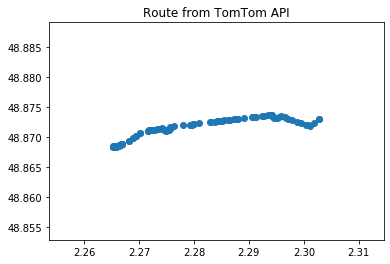

In [65]:
# Convert the points to floats    
lats = [float(x) for x in lats]
longs = [float(x) for x in longs]
# Import the plotting library
import matplotlib.pyplot as plt
plt.scatter(longs,lats)
plt.title('Route from TomTom API')
plt.show()

In [66]:
# this is the dataframe that will contain the coordinates of all the route points
column_names3 = ['Latitude', 'Longitude'] 


route_latlon = pd.DataFrame(columns=column_names3)

In [68]:
route_latlon['Latitude'] = lats
route_latlon['Longitude'] = longs

In [69]:
route_latlon

Latitude  Longitude
0    48.87124    2.27212
1    48.87124    2.27212
2    48.87116    2.27193
3    48.87112    2.27181
4    48.87107    2.27156
5    48.87059    2.27024
6    48.87019    2.26949
7    48.86983    2.26889
8    48.86940    2.26817
9    48.86881    2.26693
10   48.86879    2.26686
11   48.86879    2.26675
12   48.86863    2.26627
13   48.86857    2.26602
14   48.86852    2.26568
15   48.86853    2.26566
16   48.86854    2.26555
17   48.86852    2.26546
18   48.86847    2.26536
19   48.86844    2.26534
20   48.86839    2.26533
21   48.86836    2.26534
22   48.86832    2.26537
23   48.86828    2.26545
24   48.86827    2.26553
25   48.86826    2.26555
26   48.86827    2.26566
27   48.86831    2.26575
28   48.86835    2.26579
29   48.86836    2.26580
30   48.86842    2.26580
31   48.86849    2.26612
32   48.86855    2.26632
33   48.86871    2.26678
34   48.86879    2.26686
35   48.86881    2.26693
36   48.86940    2.26817
37   48.86983    2.26889
38   48.87019    2.26949
39   48.87059    2.27024
40   48.87107    2.27156
41   48.87112    2.27181
42   48.87116    2.27193
43   48.87112    2.27211
44   48.87112    2.27228
45   48.87114    2.27238
46   48.87122    2.27296
47   48.87129    2.27333
48   48.87134    2.27359
49   48.87147    2.27419
50   48.87131    2.27433
51   48.87115    2.27462
52   48.87112    2.27466
53   48.87108    2.27487
54   48.87108    2.27496
55   48.87109    2.27511
56   48.87111    2.27524
57   48.87124    2.27552
58   48.87130    2.27558
59   48.87150    2.27569
60   48.87155    2.27569
61   48.87169    2.27568
62   48.87173    2.27590
63   48.87178    2.27638
64   48.87196    2.27808
65   48.87209    2.27936
66   48.87207    2.27946
67   48.87208    2.27955
68   48.87209    2.27965
69   48.87210    2.27976
70   48.87211    2.27988
71   48.87217    2.27998
72   48.87226    2.28086
73   48.87249    2.28290
74   48.87250    2.28304
75   48.87258    2.28380
76   48.87262    2.28413
77   48.87267    2.28449
78   48.87269    2.28462
79   48.87272    2.28498
80   48.87275    2.28515
81   48.87275    2.28516
82   48.87279    2.28545
83   48.87286    2.28614
84   48.87292    2.28662
85   48.87300    2.28729
86   48.87299    2.28741
87   48.87301    2.28763
88   48.87303    2.28783
89   48.87307    2.28791
90   48.87308    2.28804
91   48.87318    2.28905
92   48.87335    2.29053
93   48.87338    2.29082
94   48.87339    2.29096
95   48.87341    2.29122
96   48.87353    2.29237
97   48.87357    2.29276
98   48.87366    2.29347
99   48.87369    2.29370
100  48.87372    2.29410
101  48.87360    2.29413
102  48.87343    2.29424
103  48.87336    2.29435
104  48.87325    2.29464
105  48.87322    2.29509
106  48.87323    2.29517
107  48.87330    2.29550
108  48.87346    2.29577
109  48.87328    2.29649
110  48.87316    2.29684
111  48.87309    2.29707
112  48.87286    2.29779
113  48.87258    2.29871
114  48.87235    2.29950
115  48.87206    2.30047
116  48.87198    2.30069
117  48.87187    2.30105
118  48.87235    2.30183
119  48.87297    2.30277
120  48.87300    2.30282

In [70]:

for lat, lon in zip(route_latlon['Latitude'],route_latlon['Longitude'] ):
    folium.CircleMarker(
    location=[lat, lon],
    radius=1,
    popup= None,
    color='#3186cc'
).add_to(map_clusters)


In [71]:
map_clusters

In [72]:
for lat, lon, poi, cluster in zip(quartiers_merged['Latitude'], quartiers_merged['Longitude'], quartiers_merged['Name'], quartiers_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### We successfully managed to find a neighborhood where to look for a new house, according to our preferences and the distance from our workplace, mission completed!

![alt text](https://upload.wikimedia.org/wikipedia/commons/e/ea/Thats_all_folks.svg "Aaaand...")